In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import tree
import graphviz
import matplotlib.pyplot as plt

In [2]:
# Join entre Stress e Feedbacks
pd.options.mode.chained_assignment = None  # default='warn'

feedbacks = pd.read_csv("Feedbacks 17_08 - video_sessions_feedback.csv", parse_dates=['created_date'])
stress = pd.read_csv("Stress 17_08 - video_sessions_stressfeedback.csv", parse_dates=['created_date'])

feedbacks_stress = pd.DataFrame()

feedbacks['estresse'] = np.zeros(len(feedbacks))

for i in range(len(stress)):
    if type(stress.iloc[i]['session_id']) == str:
        feeds_to_add = feedbacks[ feedbacks['session_id'] == stress.iloc[i]['session_id'] ]
        
    else:
        feeds_to_add = feedbacks[ feedbacks['email'] == stress.iloc[i]['email'] ]
      
    feeds_to_add['estresse'] = stress.loc[i, 'estresse']
    feedbacks_stress = feedbacks_stress.append(feeds_to_add)
    


In [7]:
#normaliza os dados da versao 1 para range de 5
feedbacks_stress.loc[feedbacks_stress['versao'] == 1, ['incomodo', 'interesse1', 'interesse2'] ] //= 2


In [8]:
# inversao dos valores das sessoes que tem o primeiro video com QoS alta
feedbacks_stress = feedbacks_stress.reset_index(drop=True)

for i in range(len(feedbacks_stress.index)):
    if feedbacks_stress.loc[i, 'created_date'].month < 7:
        if feedbacks_stress.loc[i]['num_sessao'] in (1, 3, 6):
            feedbacks_stress.at[i, 'interesse1'], feedbacks_stress.at[i, 'interesse2'] = feedbacks_stress.at[i, 'interesse2'], feedbacks_stress.at[i, 'interesse1']
            if feedbacks_stress.at[i, 'num_video_preferido'] == 1:
                feedbacks_stress.at[i, 'num_video_preferido'] = 2
            else:
                feedbacks_stress.at[i, 'num_video_preferido'] = 1                   
    else:
        if feedbacks_stress.loc[i, 'num_sessao'] in (1, 5):
            feedbacks_stress.at[i, 'interesse1'], feedbacks_stress.at[i, 'interesse2'] = feedbacks_stress.at[i, 'interesse2'], feedbacks_stress.at[i, 'interesse1']
            
            if feedbacks_stress.at[i, 'num_video_preferido'] == 1:
                feedbacks_stress.at[i, 'num_video_preferido'] = 2
            else:
                feedbacks_stress.at[i, 'num_video_preferido'] = 1


In [9]:
#estatisticas basicas
feedbacks_stress.describe()

# print(feedbacks_stress.loc[7, ['incomodo', 'interesse1', 'interesse2', 'num_video_preferido', 'justificativa']])

,id,num_sessao,num_video_preferido,incomodo,interesse1,interesse2,english,versao,estresse
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,163.250000,4.129032,1.439516,3.637097,3.193548,2.479839,0.012097,1.854839,6.806452
std,77.268827,2.057740,0.497332,1.271517,1.389244,1.566216,0.109539,0.352976,2.413449
min,21.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,101.750000,2.000000,1.000000,3.000000,2.000000,1.000000,0.000000,2.000000,5.000000
50%,162.500000,4.000000,1.000000,4.000000,3.500000,3.000000,0.000000,2.000000,7.000000
75%,233.250000,6.000000,2.000000,5.000000,4.000000,4.000000,0.000000,2.000000,8.000000
max,295.000000,7.000000,2.000000,5.000000,5.000000,5.000000,1.000000,2.000000,10.000000


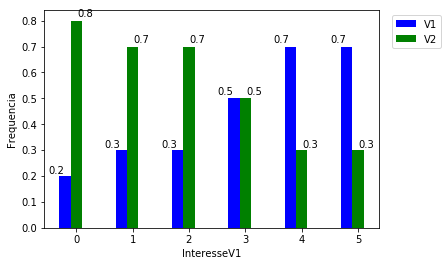

In [53]:
# grafico (interessev1 x preferencia/escolha usuario)

counts = feedbacks_stress.groupby(['interesse1','num_video_preferido'], as_index=False).size().unstack(fill_value=0).reset_index()
counts['V1_percent'] = round(counts[1]/(counts[1]+counts[2]), 1)
counts['V2_percent'] = round(counts[2]/(counts[1]+counts[2]), 1)

ax = plt.subplot()
b1 = ax.bar(counts['interesse1']-0.2, counts['V1_percent'],width=0.2,color='b',align='center')
b2 = ax.bar(counts['interesse1'], counts['V2_percent'],width=0.2,color='g',align='center')



# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend. 
xOffset = 0.1
bb.x0 += xOffset
bb.x1 += xOffset


leg = plt.legend((b1[0], b2[0]), ('V1', 'V2'), loc = 'upper right')

leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

plt.ylabel('Frequencia')
plt.xlabel('InteresseV1')


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')


autolabel(b1, "left")
autolabel(b2, "right")
plt.show()

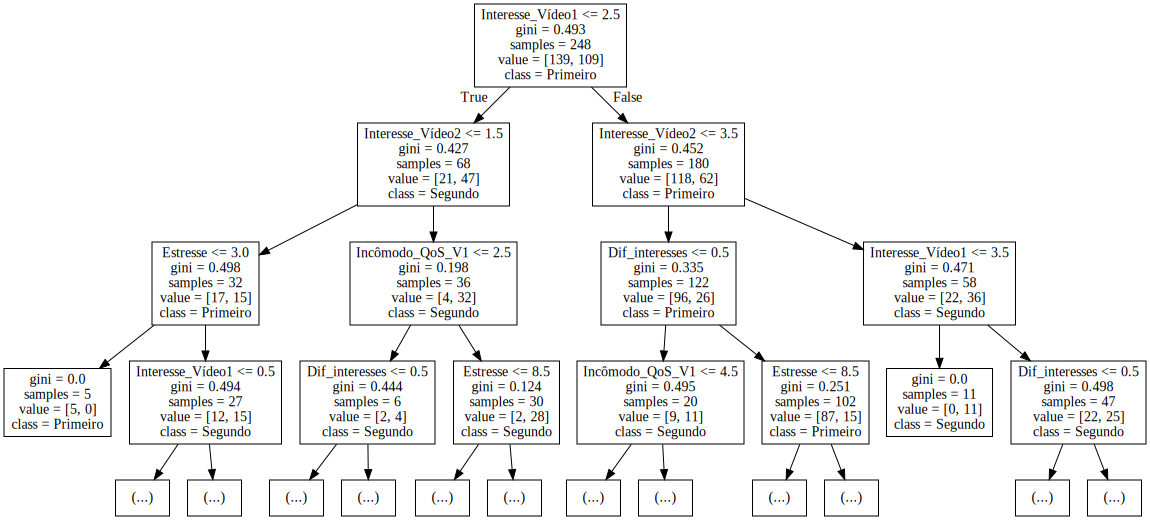

In [11]:
#Arvore de decisao

clf = tree.DecisionTreeClassifier()
feedbacks_stress['dif_interesses'] = abs(feedbacks_stress['interesse1'] - feedbacks_stress['interesse2'])
X = np.array([feedbacks_stress['incomodo'], feedbacks_stress['interesse1'], 
              feedbacks_stress['interesse2'], feedbacks_stress['dif_interesses'], feedbacks_stress['estresse']]).transpose()

Y = np.array(feedbacks_stress['num_video_preferido'])

clf.fit(X, Y)

 
feature_names=['Incômodo_QoS_V1', 'Interesse_Vídeo1', 'Interesse_Vídeo2', 'Dif_interesses', 'Estresse']
    
dot_data = tree.export_graphviz(clf, max_depth=3, feature_names=feature_names,
                                            class_names=['Primeiro', 'Segundo'],out_file=None) 
graph = graphviz.Source(dot_data)
#graph.render("feeds_1807_estresse")
graph


In [224]:
# prepara para aplicar os algoritmos de ML

label = feedbacks_stress.num_video_preferido
label = label.astype('int').reshape(-1,1)


feedbacks_stress_text = feedbacks_stress.drop(['id', 'email','num_sessao','num_video_preferido', 'created_date', 'comment','published_date', 'english', 'session_id','versao'], axis=1)
feedbacks_stress = feedbacks_stress_text.drop(['justificativa'], axis=1)


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


,id,num_sessao,num_video_preferido,incomodo,interesse1,interesse2,english,versao,estresse
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,163.250000,4.129032,1.451613,7.334677,6.193548,5.302419,0.012097,1.854839,6.806452
std,77.268827,2.057740,0.498660,2.510885,2.935687,3.039763,0.109539,0.352976,2.413449
min,21.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,101.750000,2.000000,1.000000,6.000000,4.000000,2.000000,0.000000,2.000000,5.000000
50%,162.500000,4.000000,1.000000,8.000000,6.000000,6.000000,0.000000,2.000000,7.000000
75%,233.250000,6.000000,2.000000,10.000000,8.000000,8.000000,0.000000,2.000000,8.000000
max,295.000000,7.000000,2.000000,10.000000,10.000000,10.000000,1.000000,2.000000,10.000000


In [225]:
class Results:
    def __init__(self):
        pass
    nb = []
    tree = []
    sgd = []
    lsvc = []
    svc = []
    kmeans = []
    knn = []
    rf = []
    mlp = []
    
def run_algorithms(results, df_data, label):
    #Initialize test and train data
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    x_train, x_test, y_train, y_test = train_test_split(df_data, label, test_size=0.3)
    
    #Naive Bayes
    from sklearn.naive_bayes import MultinomialNB
    nb_clf = MultinomialNB().fit(x_train, y_train)
    nb_y_pred = nb_clf.predict(x_test)
    nb_cm = confusion_matrix(y_test, nb_y_pred)
    nb_p1 = precision_score(y_test, nb_y_pred)
    nb_p2 = precision_score(y_test, nb_y_pred, pos_label=2)
    nb_p = precision_score(y_test, nb_y_pred, average='weighted')
    nb_a = accuracy_score(y_test, nb_y_pred)
    nb_r = classification_report(y_test, nb_y_pred)
    results.nb += [[nb_p1, nb_p2, nb_p, nb_a, nb_cm, nb_r]]
    
    #Decision Trees
    from sklearn import tree
    tree_clf = tree.DecisionTreeClassifier().fit(x_train, y_train)
    tree_y_pred = tree_clf.predict(x_test)
    tree_cm = confusion_matrix(y_test, tree_y_pred)
    tree_p1 = precision_score(y_test, tree_y_pred)
    tree_p2 = precision_score(y_test, tree_y_pred, pos_label=2)
    tree_p = precision_score(y_test, tree_y_pred, average='weighted')
    tree_a = accuracy_score(y_test, tree_y_pred)
    tree_r = classification_report(y_test, tree_y_pred)
    results.tree += [[tree_p1, tree_p2, tree_p, tree_a, tree_cm, tree_r]]
    
    
    #Stochastic Gradient Descent
    from sklearn.linear_model import SGDClassifier
    sgd_clf = SGDClassifier(alpha=.000001, n_iter=50000).fit(x_train, y_train)
    sgd_y_pred = sgd_clf.predict(x_test)
    sgd_cm = confusion_matrix(y_test, sgd_y_pred)
    sgd_p1 = precision_score(y_test, sgd_y_pred)
    sgd_p2 = precision_score(y_test, sgd_y_pred, pos_label=2)
    sgd_p = precision_score(y_test, sgd_y_pred, average='weighted')
    sgd_a = accuracy_score(y_test, sgd_y_pred)
    sgd_r = classification_report(y_test, sgd_y_pred)
    results.sgd += [[sgd_p1, sgd_p2, sgd_p, sgd_a, sgd_cm, sgd_r]]
    
    
    #Linear SVC
    from sklearn.svm import LinearSVC
    lsvc_clf = LinearSVC(dual=False, max_iter=10000, tol=1e-6).fit(x_train, y_train)
    lsvc_y_pred = lsvc_clf.predict(x_test)
    lsvc_cm = confusion_matrix(y_test, lsvc_y_pred)
    lsvc_p1 = precision_score(y_test, lsvc_y_pred)
    lsvc_p2 = precision_score(y_test, lsvc_y_pred, pos_label=2)
    lsvc_p = precision_score(y_test, lsvc_y_pred, average='weighted')
    lsvc_a = accuracy_score(y_test, lsvc_y_pred)
    lsvc_r = classification_report(y_test,lsvc_y_pred)
    results.lsvc += [[lsvc_p1, lsvc_p2, lsvc_p, lsvc_a, lsvc_cm, lsvc_r]]
    
    
    #SVC
    from sklearn.svm import SVC
    svc_clf = SVC(cache_size=2000, probability = True).fit(x_train, y_train)
    svc_y_pred = svc_clf.predict(x_test)
    svc_cm = confusion_matrix(y_test, svc_y_pred)
    svc_p1 = precision_score(y_test, svc_y_pred)
    svc_p2 = precision_score(y_test, svc_y_pred, pos_label=2)
    svc_p = precision_score(y_test, svc_y_pred, average='weighted')
    svc_a = accuracy_score(y_test, svc_y_pred)
    svc_r = classification_report(y_test,svc_y_pred) 
    results.svc += [[svc_p1, svc_p2, svc_p, svc_a, svc_cm, svc_r]]
    

    
    #KNN Classifier
    from sklearn.neighbors import KNeighborsClassifier
    knn_clf = KNeighborsClassifier(n_neighbors=15).fit(x_test, y_test)
    knn_y_pred = knn_clf.predict(x_test)
    knn_cm = confusion_matrix(y_test, knn_y_pred)
    knn_p1 = precision_score(y_test, knn_y_pred)
    knn_p2 = precision_score(y_test, knn_y_pred, pos_label=2)
    knn_p = precision_score(y_test, knn_y_pred, average='weighted')
    knn_a = accuracy_score(y_test, knn_y_pred)
    knn_r = classification_report(y_test, knn_y_pred)
    results.knn += [[knn_p1, knn_p2, knn_p, knn_a, knn_cm, knn_r]]
    
    #Random Forest Algorithm
    from sklearn.ensemble import RandomForestClassifier 
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=0).fit(x_train, y_train)
    rf_y_pred = rf_clf.predict(x_test)
    rf_cm = confusion_matrix(y_test, rf_y_pred)
    rf_p1 = precision_score(y_test, rf_y_pred)
    rf_p2 = precision_score(y_test, rf_y_pred, pos_label=2)
    rf_p = precision_score(y_test, rf_y_pred, average='weighted')
    rf_a = accuracy_score(y_test, rf_y_pred)
    rf_r = classification_report(y_test, rf_y_pred)
    results.rf += [[rf_p1, rf_p2, rf_p, rf_a, rf_cm, rf_r]]
    
    
    #Neural Network
    from sklearn.neural_network import MLPClassifier
    mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100,150), max_iter=1000).fit(x_train, y_train)
    mlp_y_pred = mlp_clf.predict(x_test)
    mlp_cm = confusion_matrix(y_test, mlp_y_pred)
    mlp_p1 = precision_score(y_test, mlp_y_pred)
    mlp_p2 = precision_score(y_test, mlp_y_pred, pos_label=2)
    mlp_p = precision_score(y_test, mlp_y_pred, average='weighted')
    mlp_a = accuracy_score(y_test, mlp_y_pred)
    mlp_r = classification_report(y_test, mlp_y_pred)
    results.mlp += [[mlp_p1, mlp_p2, mlp_p, mlp_a, mlp_cm, mlp_r]]
    
    return results

def print_results(results):
    #Write to file
    writer = pd.ExcelWriter('output.xlsx')
    df_nb = pd.DataFrame(data=results.nb, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_tree = pd.DataFrame(data=results.tree, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_sgd = pd.DataFrame(data=results.sgd, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_lsvc = pd.DataFrame(data=results.lsvc, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_svc = pd.DataFrame(data=results.svc, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_knn = pd.DataFrame(data=results.knn, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_rf = pd.DataFrame(data=results.rf, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_mlp = pd.DataFrame(data=results.mlp, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    
    writer = pd.ExcelWriter('output.xlsx')
    df_nb.to_excel(writer,'Naive Bayes')
    df_tree.to_excel(writer,'Decision Tree')
    df_sgd.to_excel(writer,'Stochastic Gradient Descent')
    df_lsvc.to_excel(writer,'Linear SVC')
    df_svc.to_excel(writer,'Support Vector Classification')
    df_knn.to_excel(writer,'K-Nearest Neighbors')
    df_rf.to_excel(writer,'Random Forest')
    df_mlp.to_excel(writer,'Multi Layer Perceptron')

    writer.save()
    

In [226]:
#Main():
container = Results()
for i in range(10):
    container = run_algorithms(container, feedbacks_stress, label)
    
print_results(container)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWar

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWar

In [45]:
a = 2.423523
round(a, 2)

2.42